In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from torch import optim
import logging
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchsummary import summary
import gc
from IPython.display import clear_output

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# UNet

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm(channels)
        self.ff_self = nn.Sequential(
            nn.LayerNorm(channels),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, H * W).permute(0, 2, 1)  # (B, H*W, C)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.permute(0, 2, 1).view(B, C, H, W)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, device=DEVICE, c_in=3, c_out=3, time_dim=256):
        super().__init__()
        self.device = device
        self.time_dim = time_dim

        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)

        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

# Класс диффузии

In [4]:
class Diffusion:
    def __init__(
            self,
            noise_steps=1000,   # количество шагов зашумления
            beta_start=1e-4,    # начальное значение параметра beta
            beta_end=0.02,      # конечное значение параметра beta
            img_size=256,       # размер изображения
            device=DEVICE,
            ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        # создадим массив параметров beta
        self.beta = self.prepare_noise_schedule().to(device)
        # вычислим параметр alpha
        self.alpha = 1. - self.beta
        # посчитаем массив alpha_hat
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        # зашуим изображения
        # доп. размерности указыванием для согласования с размерностями х
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        # инициализируем шаги зашумления как случайный вектор
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    
    def sample(self, model, n, step=1):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in reversed(range(step, self.noise_steps, step)):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = torch.sqrt(self.alpha_hat[t-step][:, None, None, None]) * (x - (torch.sqrt(1 - alpha_hat) * predicted_noise)) / torch.sqrt(alpha_hat) + torch.sqrt(1 - self.alpha_hat[t-step][:, None, None, None]) * predicted_noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        return (x * 255).type(torch.uint8)






Логика сэмплирования для метода **sample** выше:
$$
x_{t-1} = \sqrt{\alpha_{t-1}} \left( \frac{x_t - \sqrt{1 - \alpha_t} \epsilon_{\theta}^{(t)}(x_t)}{\sqrt{\alpha_t}} \right)
+ \sqrt{1 - \alpha_{t-1} - \sigma_t ^2} \cdot \epsilon_{\theta}^{(t)}(x_t)
+ \sigma_t * \epsilon
$$

# Эксперименты

In [5]:
N_IMAGES = 9

def visualize_pictures(generated_images):
  num_pictures_in_row = int(np.sqrt(generated_images.shape[0]))
  fig, axes = plt.subplots(num_pictures_in_row, num_pictures_in_row, figsize=(9, 9))
  for i in range(num_pictures_in_row):
      for j in range(num_pictures_in_row):
          axes[i, j].imshow(generated_images[i * num_pictures_in_row + j].cpu().numpy().transpose(1,2,0))
  for ax in axes.flat:
      ax.axis('off')
  plt.tight_layout()


def do_experiment(n_images, noise_steps, img_size=64, step=1):
  diffusion = Diffusion(img_size=img_size, noise_steps=noise_steps)
  generated_images = diffusion.sample(model, n_images, step=step)
  visualize_pictures(generated_images)

In [6]:
model = UNet().to(DEVICE)
model.load_state_dict(torch.load('./ckpt.pt', map_location=torch.device(DEVICE)))
clear_output()

### Посмотрим с какого числа шагов noise_steps начнется сходимость.

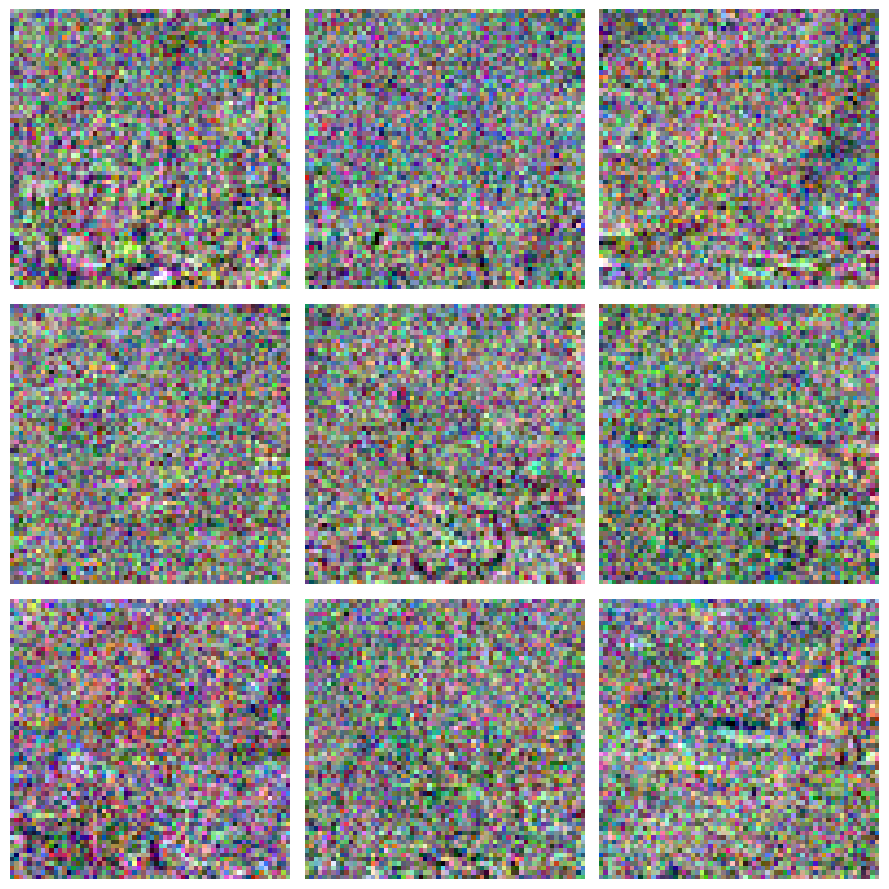

In [7]:
do_experiment(N_IMAGES, noise_steps=100)

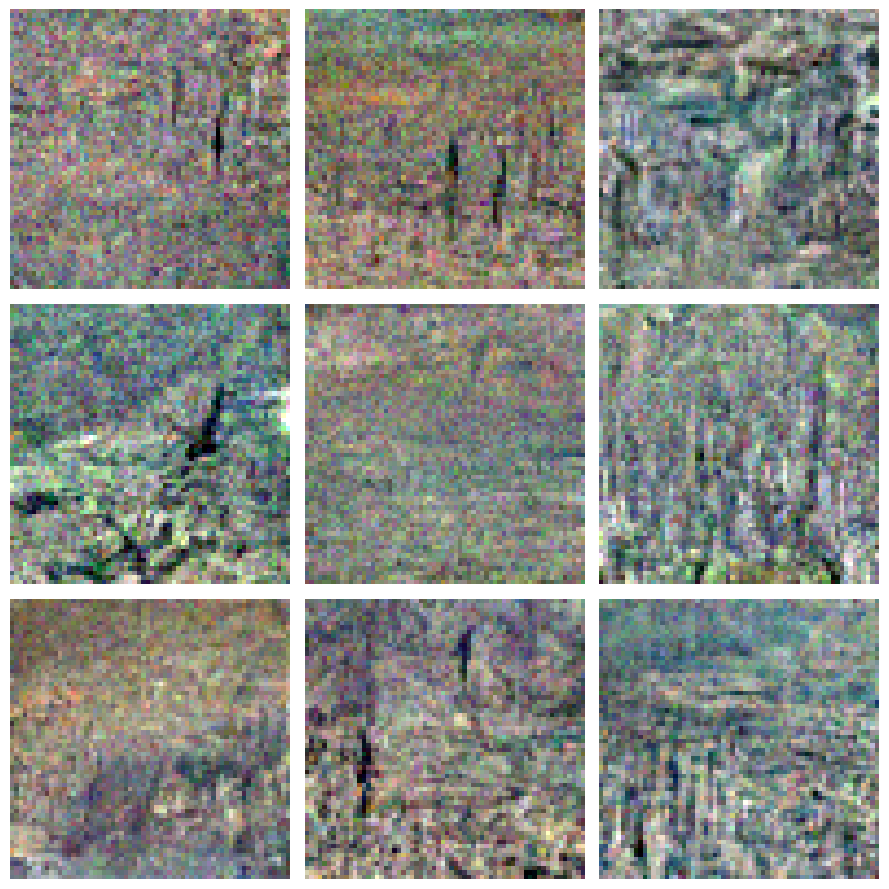

In [8]:
do_experiment(N_IMAGES, noise_steps=250)

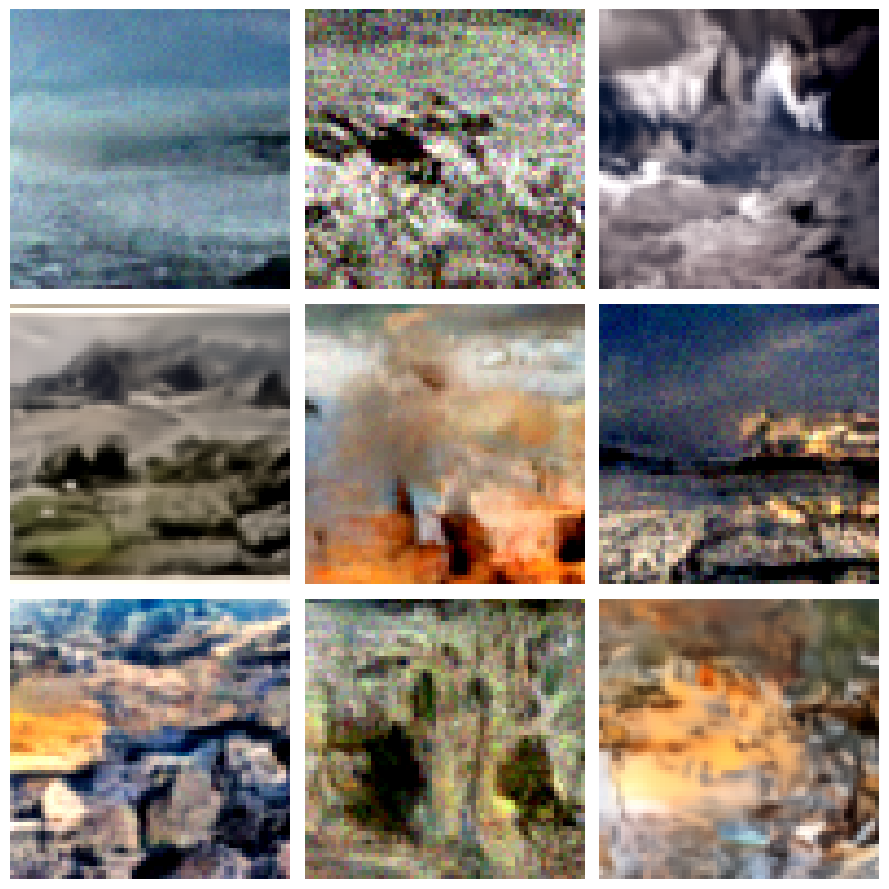

In [9]:
do_experiment(N_IMAGES, noise_steps=500)

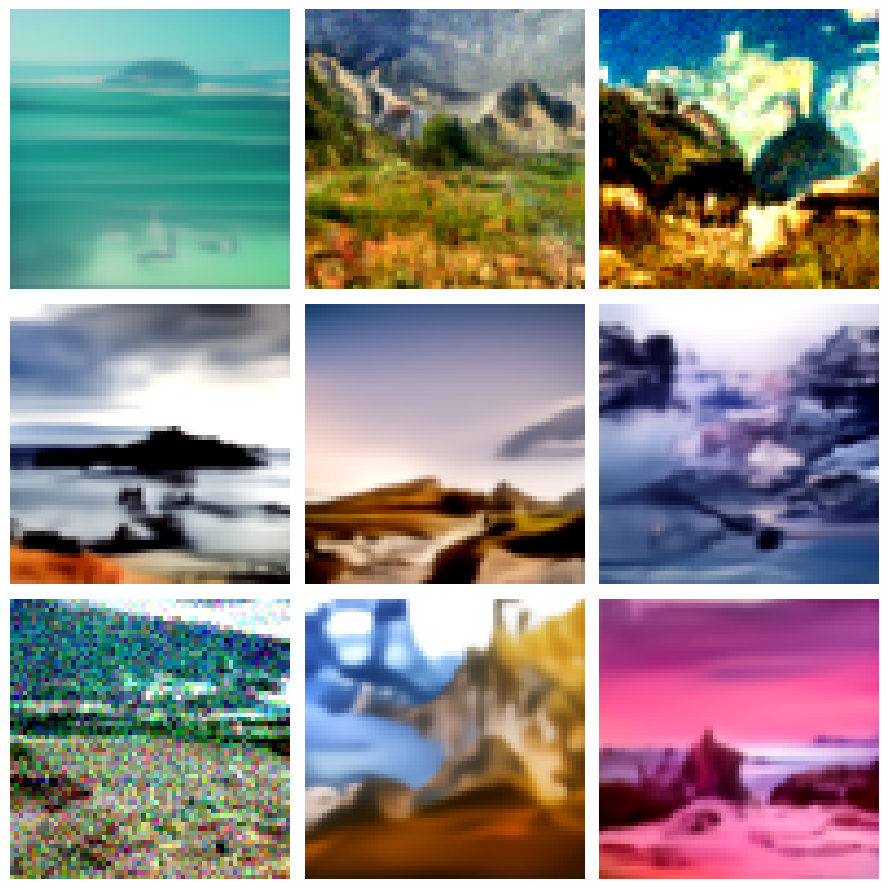

In [10]:
do_experiment(N_IMAGES, noise_steps=600)

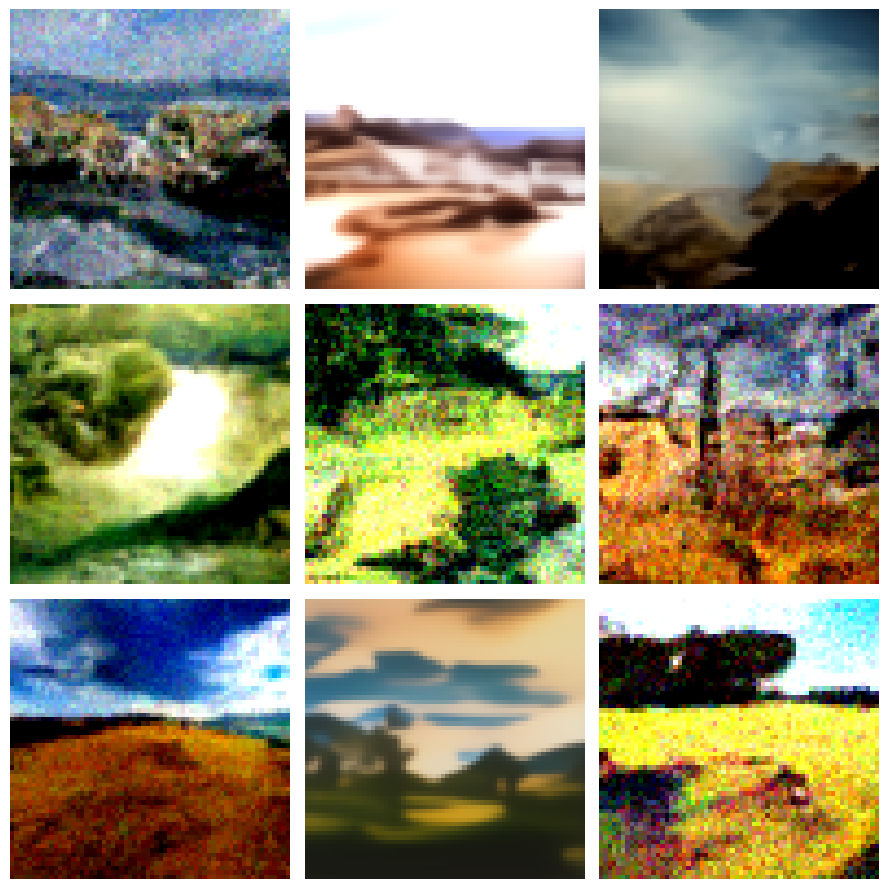

In [11]:
do_experiment(N_IMAGES, noise_steps=700)

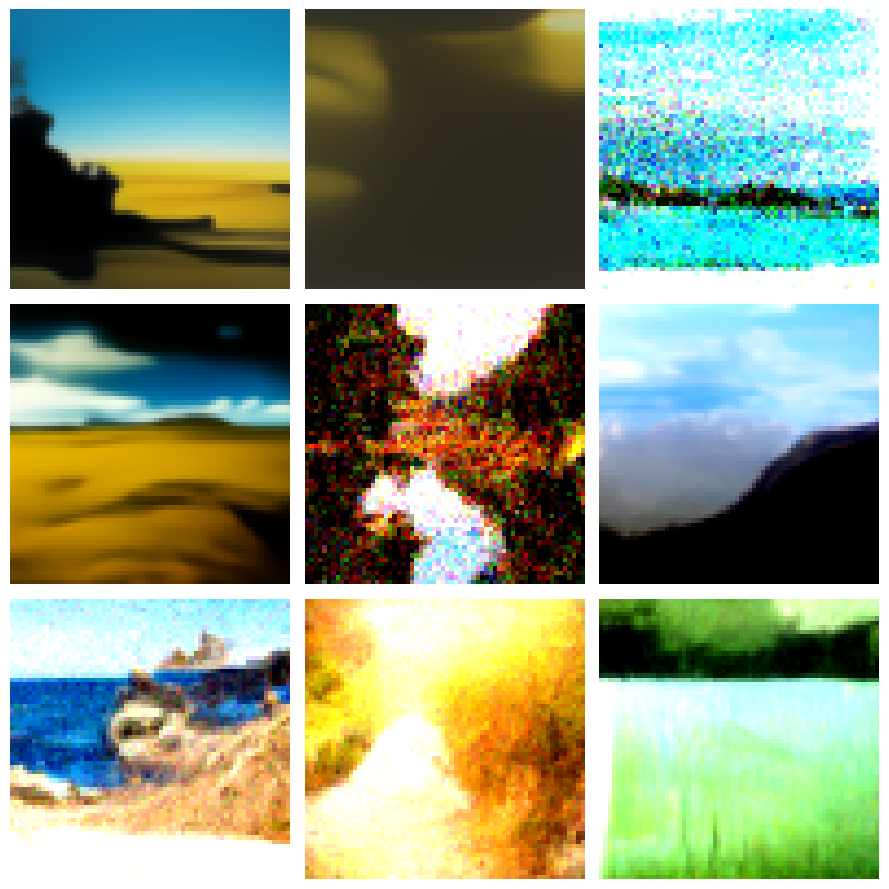

In [12]:
do_experiment(N_IMAGES, noise_steps=800)

#### Сходится с примерно 600 шагов. Зафиксируем число шагов 800 и будем менять step.

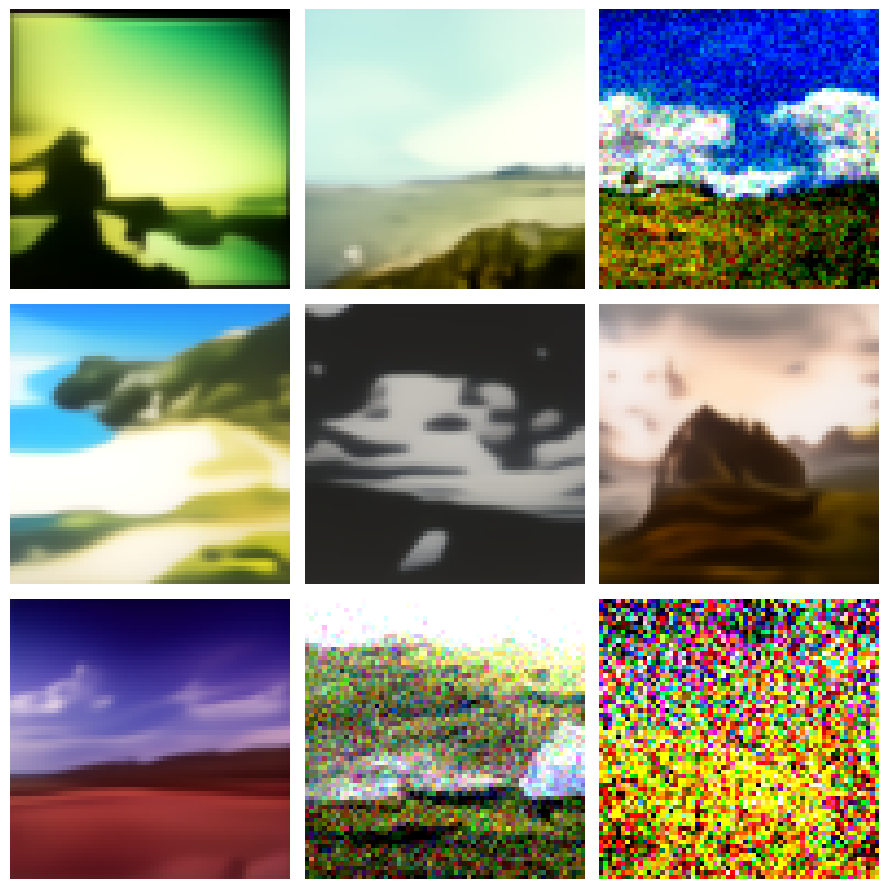

In [13]:
do_experiment(N_IMAGES, noise_steps=800, img_size=64, step=1)

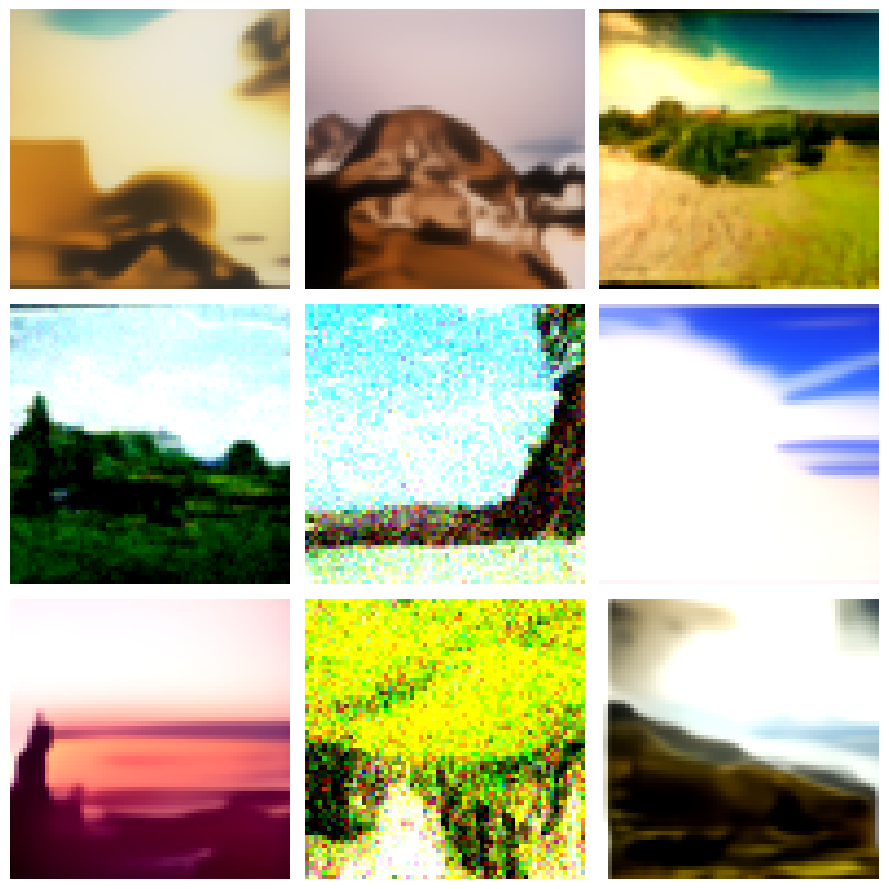

In [14]:
do_experiment(N_IMAGES, noise_steps=800, img_size=64, step=2)

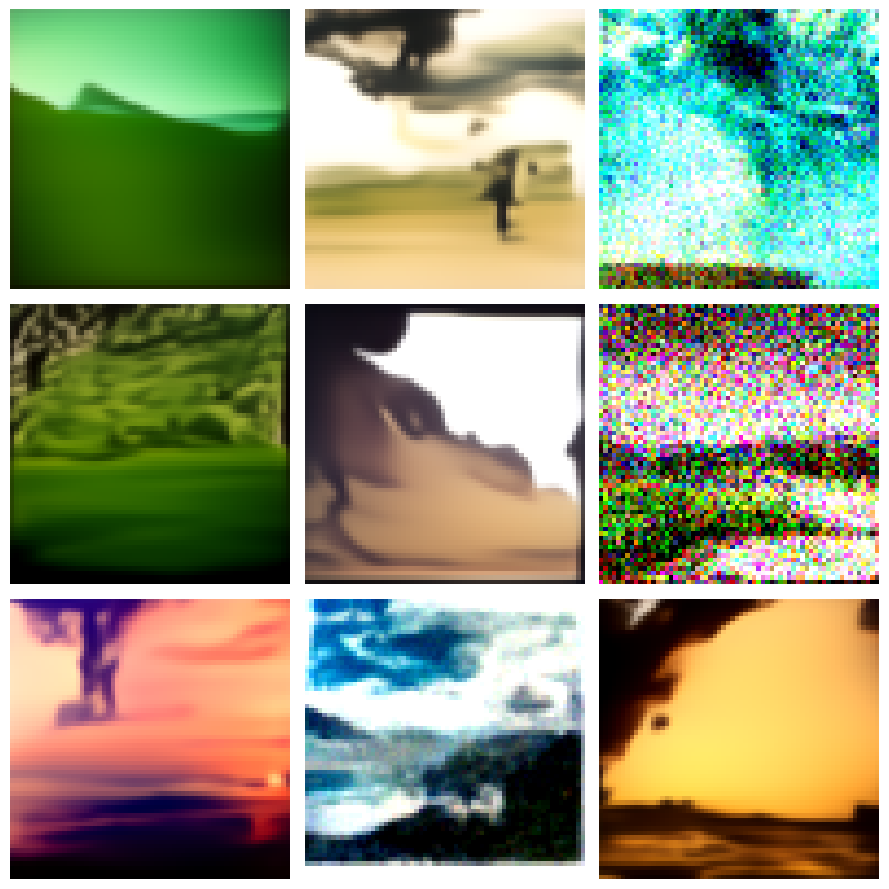

In [15]:
do_experiment(N_IMAGES, noise_steps=800, img_size=64, step=5)

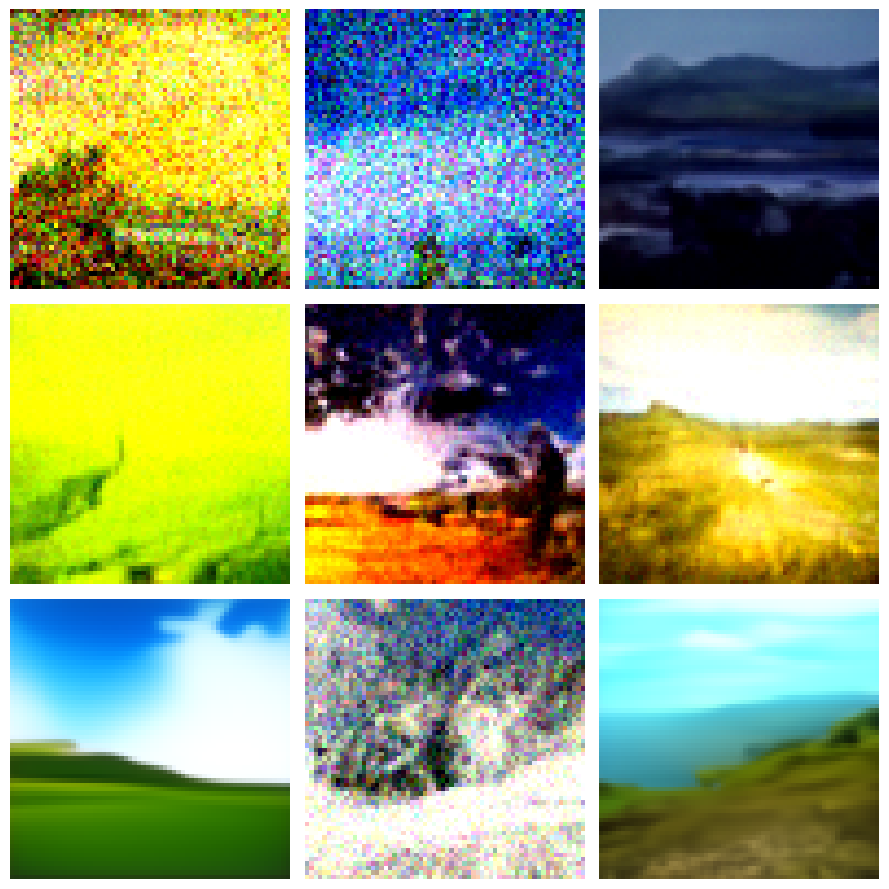

In [16]:
do_experiment(N_IMAGES, noise_steps=800, img_size=64, step=10)

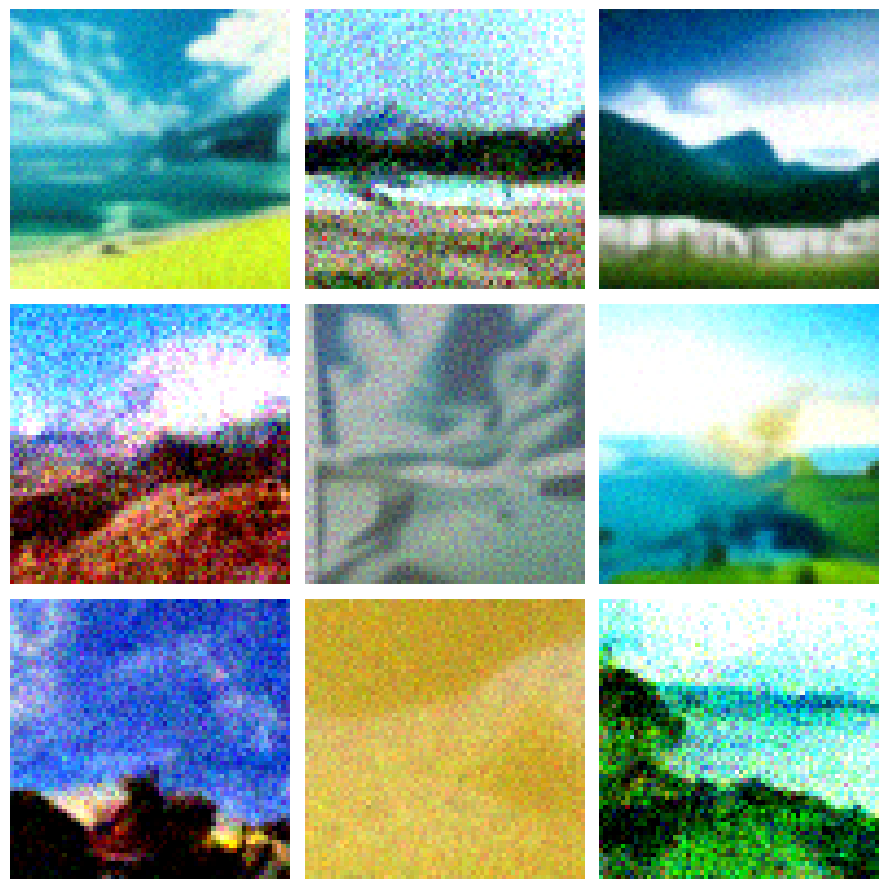

In [17]:
do_experiment(N_IMAGES, noise_steps=800, img_size=64, step=50)